In [7]:
# Cela 1
# PASO 1: PREPARACIÓN DE DATOS
#

import sqlite3
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_data_from_db(db_name="fightaging_articles.db"):
    """Carga los artículos de la base de datos a un DataFrame de Pandas."""
    try:
        conn = sqlite3.connect(db_name)
        df = pd.read_sql_query("SELECT * FROM articles", conn)
        conn.close()
        df['publish_date'] = pd.to_datetime(df['publish_date'])
        print(f"Se cargaron {len(df)} artículos de la base de datos.")
        return df
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return pd.DataFrame()

def clean_text(text):
    """
    Función para limpiar el texto:
    1. Convierte a minúsculas.
    2. Elimina puntuación y números.
    3. Separa el texto en palabras (tokenización).
    4. Elimina "stop words" (palabras comunes en inglés).
    5. Elimina palabras muy cortas (1 o 2 letras).
    """
    # 1. Minúsculas
    text = text.lower()
    
    # 2. Eliminar puntuación y números usando expresiones regulares
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenización (dividir en palabras)
    tokens = word_tokenize(text)
    
    # 4. Eliminar stop words
    stop_words = set(stopwords.words('english'))
    
    # Añadimos algunas palabras personalizadas que son muy comunes en este contexto
    # pero que no aportan mucho significado para diferenciar temas.
    custom_stop_words = [
        'welcome', 'fight', 'also', 'study', 'research', 'aging', 'age', 'may', 
        'however', 'results', 'data', 'found', 'open', 'access', 
        'great', 'deal', 'one', 'even', 'work', 'life', 'people', 'years', 'healthy',
        'life', 'longevity', 'human'
    ]
    stop_words.update(custom_stop_words)
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Eliminar palabras muy cortas
    filtered_tokens = [word for word in filtered_tokens if len(word) > 2]
    
    # Unir las palabras de nuevo en un solo string
    return " ".join(filtered_tokens)


# --- Ejecución del Paso 1 ---

if __name__ == "__main__":
    articles_df = load_data_from_db()

    if not articles_df.empty:
        # Combinamos título y cuerpo para un análisis más completo
        articles_df['full_text'] = articles_df['title'] + ' ' + articles_df['body']
        
        print("\nLimpiando y preprocesando el texto de los artículos...")
        # Aplicamos la función de limpieza a cada artículo
        articles_df['cleaned_text'] = articles_df['full_text'].apply(clean_text)
        
        # Mostramos una comparación del antes y el después
        print("\nEjemplo de limpieza:")
        print("--- TEXTO ORIGINAL ---")
        print(articles_df['full_text'].iloc[1][:500]) # Muestra los primeros 500 caracteres
        print("\n--- TEXTO LIMPIO ---")
        print(articles_df['cleaned_text'].iloc[1][:500])
        
        # Guardamos el DataFrame procesado para no tener que repetir este paso
        articles_df.to_pickle("articles_cleaned.pkl")
        print("\nDataFrame con texto limpio guardado en 'articles_cleaned.pkl'")

Se cargaron 18753 artículos de la base de datos.

Limpiando y preprocesando el texto de los artículos...

Ejemplo de limpieza:
--- TEXTO ORIGINAL ---
The Fight Aging! Disclaimer Please read this disclaimer carefully. It is a commonsense statement that should apply to all health information you find online. Your health is valuable and easily damaged. What is good advice for one person may not be good advice for another: people vary considerably in health matters. Information provided on Fight Aging! should always be discussed with a qualified physician. It is not intended to replace the relationship between you and your physician. It is recomm

--- TEXTO LIMPIO ---
disclaimer please read disclaimer carefully commonsense statement apply health information find online health valuable easily damaged good advice person good advice another vary considerably health matters information provided always discussed qualified physician intended replace relationship physician recommended follow topi

In [8]:
# Celda 2
# PASO 2: VECTORIZACIÓN
#

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Cargamos el DataFrame que limpiamos en el paso anterior
try:
    articles_df = pd.read_pickle("articles_cleaned.pkl")
    print("DataFrame con texto limpio cargado correctamente.")
except FileNotFoundError:
    print("Error: El archivo 'articles_cleaned.pkl' no fue encontrado.")
    print("Por favor, ejecuta primero el script del Paso 1 para generar este archivo.")
    exit()

# Nos aseguramos de que no haya textos vacíos que puedan causar problemas
articles_df.dropna(subset=['cleaned_text'], inplace=True)
corpus = articles_df['cleaned_text']


DataFrame con texto limpio cargado correctamente.


In [9]:
import pandas as pd
import spacy
from tqdm.auto import tqdm
import os

# --- PARÁMETROS DE CONTROL ---
SAMPLE_MODE = False  # 👈 Cambia a False para procesar todos los datos
SAMPLE_SIZE = 200   # Define cuántos artículos usar en el modo de muestra
# -----------------------------

# --- CORRECCIÓN: Nombre de archivo unificado ---
output_file = "articles_with_final_entities.pkl"

if os.path.exists(output_file) and not SAMPLE_MODE:
    print(f"✅ El archivo '{output_file}' ya existe. Saltando el paso y cargando.")
    df = pd.read_pickle(output_file)
else:
    print("\n--- PASO 4 (Sin Reglas): EXTRACCIÓN CON DOBLE MODELO ---")

    # 1. Carga del DataFrame
    df = pd.read_pickle("articles_cleaned.pkl")
    if SAMPLE_MODE:
        print(f"⚠️  MODO DE MUESTRA ACTIVO. Procesando {SAMPLE_SIZE} artículos.")
        df = df.sample(n=SAMPLE_SIZE, random_state=42)

    # 2. Cargar AMBOS modelos
    print("Cargando modelo general 'en_core_web_sm' (para siglas)...")
    nlp_general = spacy.load("en_core_web_sm")
    
    print("Cargando modelo experto 'en_core_sci_lg' (para conceptos)...")
    nlp_experto = spacy.load("en_core_sci_lg")

    # 3. Definición de la función de extracción (SIN EntityRuler)
    def extract_entities_doble_modelo(text: str) -> dict:
        entities = {}
        # Extractor A: Modelo General para descubrir siglas
        doc_general = nlp_general(text, disable=['parser', 'tagger'])
        for ent in doc_general.ents:
            if ent.label_ in ['ORG', 'PRODUCT']:
                if len(ent.text.split()) <= 2 and len(ent.text) < 15:
                     entities.setdefault('ACRONYM_OR_BIOMARKER', []).append(ent.text)

        # Extractor B: Modelo Experto para descubrir entidades biomédicas
        doc_experto = nlp_experto(text, disable=['parser', 'tagger'])
        expert_labels = ['GENE_OR_GENE_PRODUCT', 'CHEMICAL', 'DISEASE', 'THERAPEUTIC', 'METHOD']
        for ent in doc_experto.ents:
            if ent.label_ in expert_labels:
                entities.setdefault(ent.label_, []).append(ent.text)
        
        # Limpiar duplicados
        for label in entities:
            entities[label] = list(set(entities[label]))
        return entities

    # 4. Aplicar la nueva función
    print(f"Aplicando NER con doble modelo a {len(df)} artículos...")
    TEXTO_FUENTE_NER = df['full_text'].fillna('')
    tqdm.pandas()
    df['final_entities'] = TEXTO_FUENTE_NER.progress_apply(extract_entities_doble_modelo)

    # 5. Guardado
    print("\n✅ Extracción de entidades completada.")
    if not SAMPLE_MODE:
        df.to_pickle(output_file)
        print(f"\n✅ DataFrame completo guardado en '{output_file}'.")

print("\n--- DataFrame 'df' listo para el análisis en la siguiente celda ---")


--- PASO 4 (Sin Reglas): EXTRACCIÓN CON DOBLE MODELO ---
Cargando modelo general 'en_core_web_sm' (para siglas)...
Cargando modelo experto 'en_core_sci_lg' (para conceptos)...
Aplicando NER con doble modelo a 18753 artículos...


  0%|          | 0/18753 [00:00<?, ?it/s]/media/flan/Bodega4T1/CodeProjects/AgingLiterature/.venv2/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 18753/18753 [36:23<00:00,  8.59it/s]  



✅ Extracción de entidades completada.

✅ DataFrame completo guardado en 'articles_with_final_entities.pkl'.

--- DataFrame 'df' listo para el análisis en la siguiente celda ---



--- PASO 5: ANÁLISIS Y VISUALIZACIÓN DE TENDENCIAS ---

Filtrando resultados...
Se encontraron 17822 menciones de entidades relevantes después de filtrar.

--- Top 30 Moléculas, Tratamientos y Genes (Resultado Filtrado) ---
entity_name
SASP             301
Drosophila       245
IGF-1            208
mTOR             181
IL-6             161
Hayflick         160
NAD+             154
Alcor            109
SIRT1            107
AMPK             100
Autophagy         90
APOE              83
mTORC1            76
IL-1β             71
MPrize            65
Rapamycin         63
NLRP3             62
VEGF              60
FOXO              51
TGF-β             50
Kurzweil          50
Caloric           46
Huntington        45
C57BL/6J          44
IL-10             41
Cryonics          39
Laron             37
Hematopoietic     37
Biobank           35
Calico            35
Name: count, dtype: int64

Generando gráfico para: Biomarcadores y Químicos


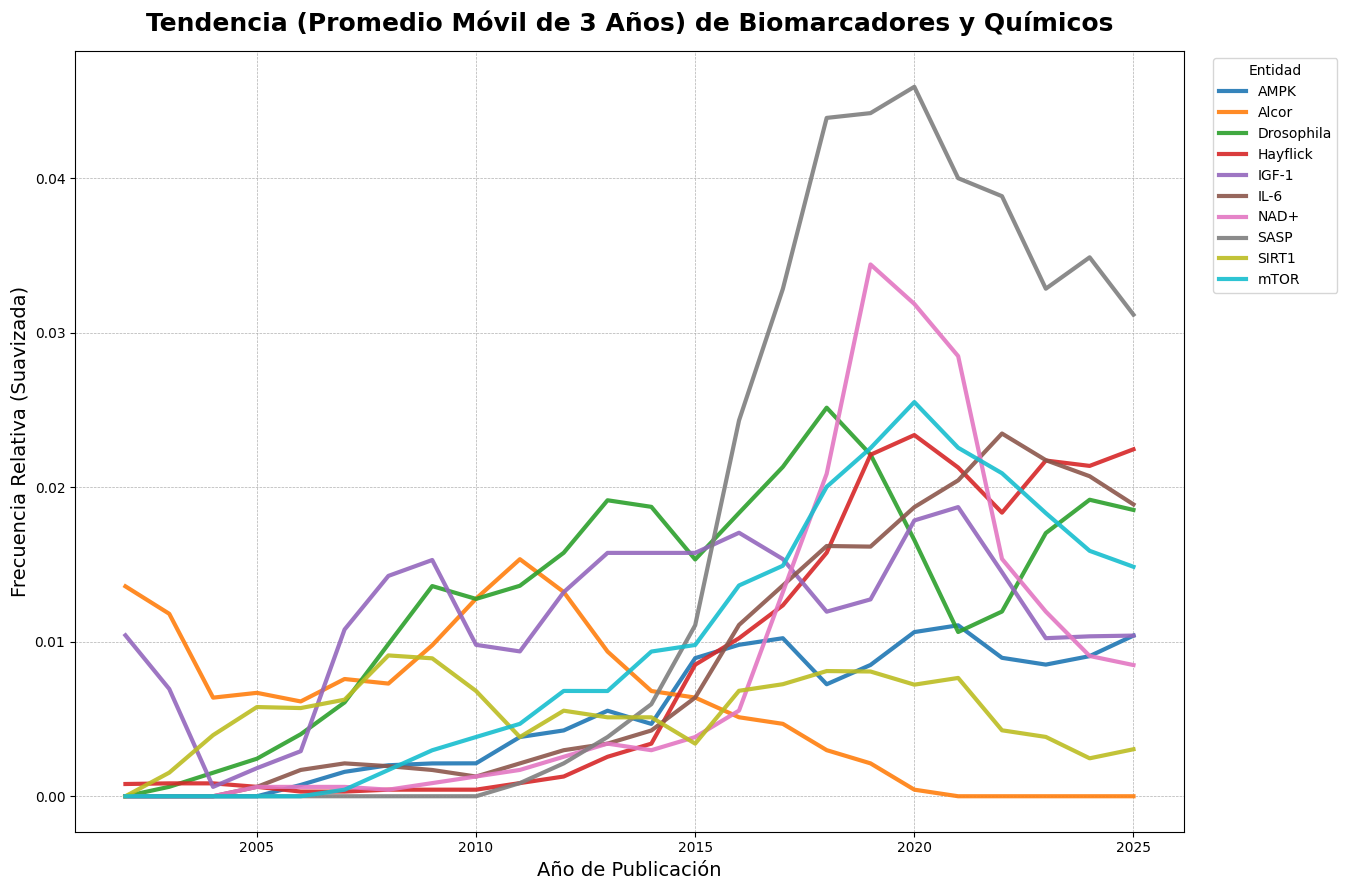


No se encontraron datos para el grupo de gráficos: Terapias y Enfermedades


In [46]:
# PASO 5: ANÁLISIS Y VISUALIZACIÓN DE TENDENCIAS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n--- PASO 5: ANÁLISIS Y VISUALIZACIÓN DE TENDENCIAS ---")

# El DataFrame 'df' ya existe en memoria o se puede cargar si se reinicia el kernel
if 'df' not in locals():
    try:
        print("DataFrame no encontrado en memoria, cargando desde archivo...")
        df = pd.read_pickle("articles_with_final_entities.pkl")
    except FileNotFoundError:
        print("❌ Error: 'articles_with_final_entities.pkl' no encontrado. Ejecuta la celda anterior primero.")
        exit()

# 1. Desanidar y filtrar las entidades
df['year'] = pd.to_datetime(df['publish_date']).dt.year
entities_list = []
for index, row in df.iterrows():
    year = row['year']
    article_id = index
    for label, entities in row.get('final_entities', {}).items():
        for entity in entities:
            entities_list.append({
                'year': year, 'entity_name': entity.strip(), 'entity_type': label, 'article_id': article_id
            })
entities_df = pd.DataFrame(entities_list)

stop_entities = [
    'aging', 'research', 'years', 'mice', 'cells', 'researchers', 'people', 'human', 'age', 'longevity', 'brain', 
    'study', 'associated with', 'healthy', 'patients', 'levels', 'increased', 'results', 'studies', 'disease', 
    'development', 'damage', 'life', 'health', 'effects', 'years ago', 'body', 'dna', 'treatments', 'treatment', 
    'cell', 'data', 'information', 'university', 'institute', 'foundation', 'sciencedaily', 'fight aging', 'aging evidence',
    'eurekalert', 'google', 'linear', 'time', 'harvard', 'longevity meme', 'methuselah', 'medical news', 'pubmed', 'youtube',
    'msnbc', 'stanford', 'medicare', 'futurepundit', 'science', 'congress', 'ending aging', 'senate', 'ucla'
]
TARGET_LABELS = [
    'ACRONYM_OR_BIOMARKER', 'GENE_OR_GENE_PRODUCT', 'CHEMICAL', 'THERAPEUTIC', 'DISEASE', 'METHOD'
]

print("\nFiltrando resultados...")
entities_df['entity_lower'] = entities_df['entity_name'].str.lower()
clean_entities_df = entities_df[~entities_df['entity_lower'].isin(stop_entities)]
clean_entities_df = clean_entities_df[clean_entities_df['entity_name'].str.len() > 3]
clean_entities_df = clean_entities_df[clean_entities_df['entity_type'].isin(TARGET_LABELS)]
print(f"Se encontraron {len(clean_entities_df)} menciones de entidades relevantes después de filtrar.")

# 2. Análisis de Top Entidades (lo que antes era la Celda B)
print("\n--- Top 30 Moléculas, Tratamientos y Genes (Resultado Filtrado) ---")
print(clean_entities_df['entity_name'].value_counts().head(30))

# 3. Preparación para la Visualización de Tendencias
entity_groups = {
    'Biomarcadores y Químicos': ['ACRONYM_OR_BIOMARKER', 'GENE_OR_GENE_PRODUCT', 'CHEMICAL'],
    'Terapias y Enfermedades': ['THERAPEUTIC', 'DISEASE', 'METHOD']
}
unique_mentions = clean_entities_df.drop_duplicates(subset=['year', 'entity_name', 'article_id'])
entity_trends = unique_mentions.groupby(['year', 'entity_name', 'entity_type']).size().reset_index(name='count')
total_articles_per_year = df.groupby('year').size().reset_index(name='total_articles')
entity_trends = pd.merge(entity_trends, total_articles_per_year, on='year')
entity_trends['frequency'] = entity_trends['count'] / entity_trends['total_articles']

# 4. Iterar y Graficar
for group_name, labels in entity_groups.items():
    group_df = entity_trends[entity_trends['entity_type'].isin(labels)]
    if group_df.empty:
        print(f"\nNo se encontraron datos para el grupo de gráficos: {group_name}")
        continue

    N_TOP_ENTITIES = 10
    top_entities_in_group = group_df.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
    plot_df = group_df[group_df['entity_name'].isin(top_entities_in_group)]
    
    if plot_df.empty:
        print(f"\nNo hay suficientes datos en el top {N_TOP_ENTITIES} para graficar el grupo: {group_name}")
        continue

    all_years = range(df['year'].min(), df['year'].max() + 1)
    plot_pivot = plot_df.pivot_table(index='year', columns='entity_name', values='frequency').reindex(all_years).fillna(0)
    smoothed_pivot = plot_pivot.rolling(window=3, min_periods=1, center=True).mean()
    plot_ready_df = smoothed_pivot.melt(var_name='entity_name', value_name='smoothed_frequency', ignore_index=False).reset_index()

    print(f"\nGenerando gráfico para: {group_name}")
    plt.figure(figsize=(16, 9))
    sns.lineplot(data=plot_ready_df, x='year', y='smoothed_frequency', hue='entity_name', linewidth=3, alpha=0.9)
    plt.title(f'Tendencia (Promedio Móvil de 3 Años) de {group_name}', fontsize=18, weight='bold', pad=15)
    plt.xlabel('Año de Publicación', fontsize=14)
    plt.ylabel('Frecuencia Relativa (Suavizada)', fontsize=14)
    plt.legend(title='Entidad', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f'tendencia_{group_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()


--- PASO 7: Generando Heatmap de Tendencias de Entidades ---


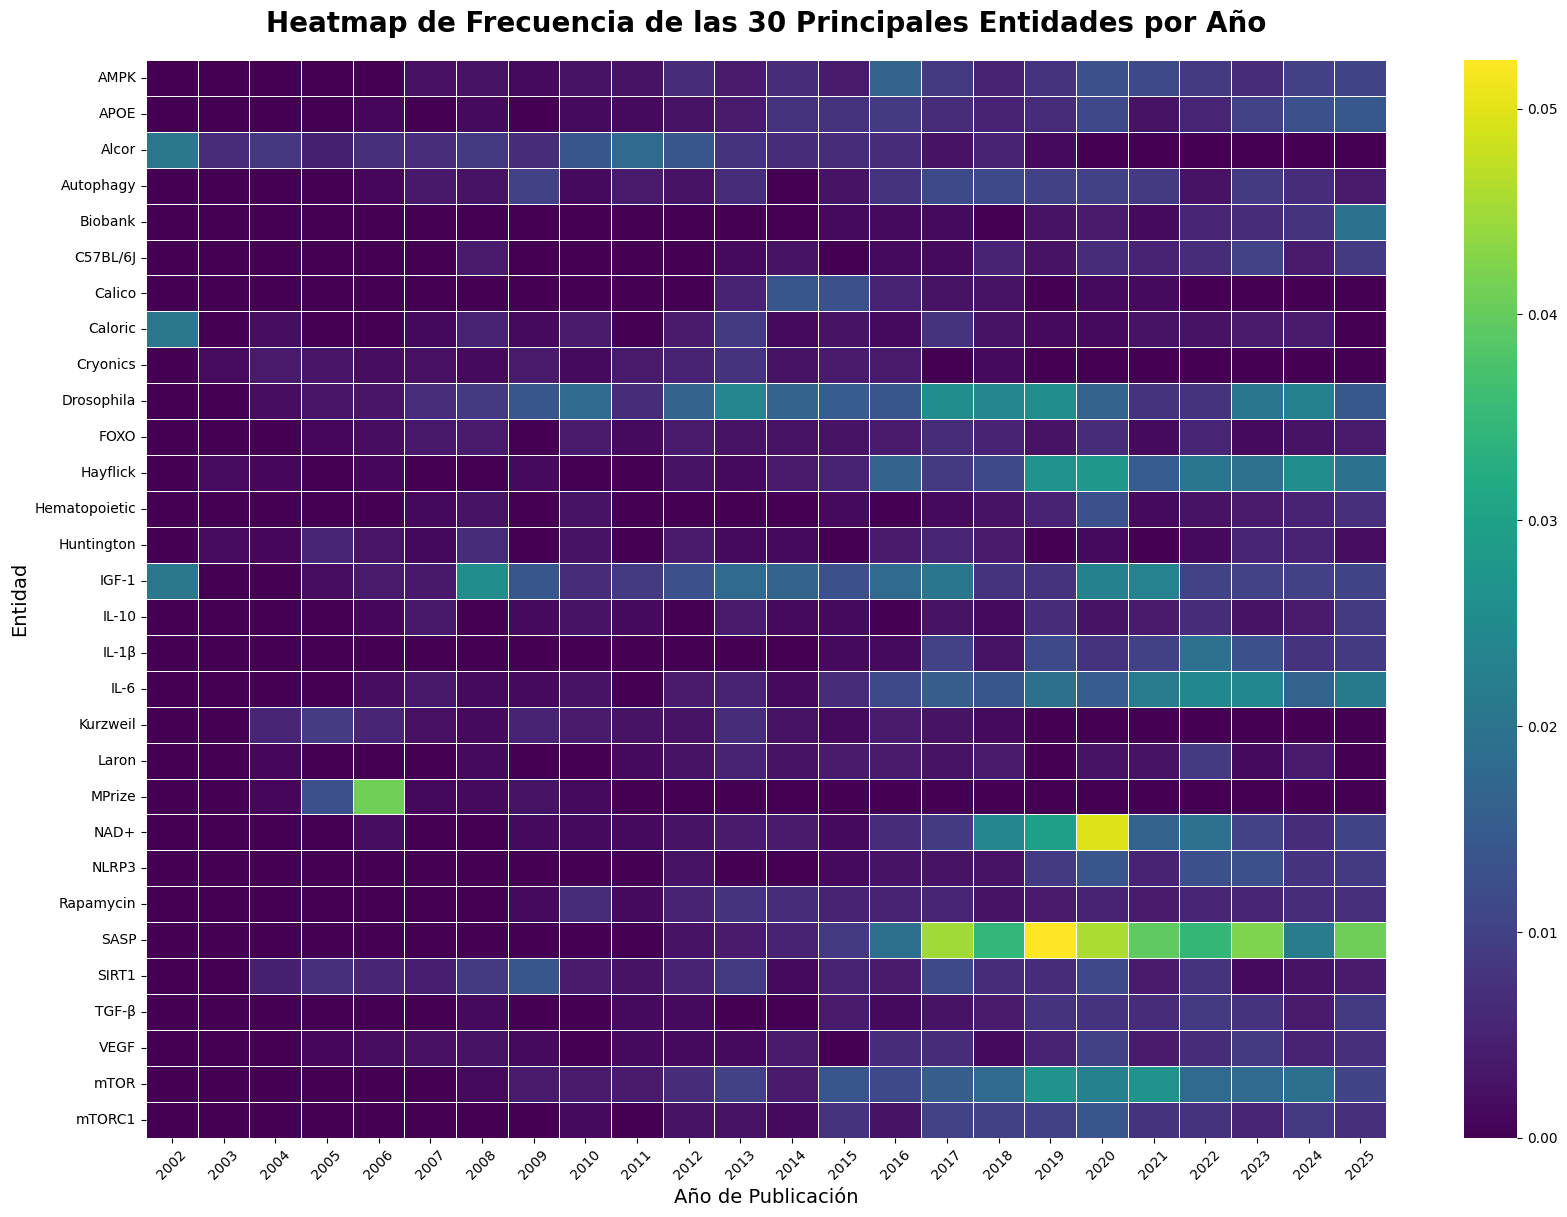

In [47]:
# PASO 7: VISUALIZACIÓN CON HEATMAP

print("\n--- PASO 7: Generando Heatmap de Tendencias de Entidades ---")

# Asumimos que 'entity_trends' existe de la celda anterior

# 1. Seleccionar las Top 30 entidades para una vista más completa
N_TOP_ENTITIES = 30
top_entities = entity_trends.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
heatmap_df = entity_trends[entity_trends['entity_name'].isin(top_entities)]

# 2. Pivotar la tabla para el formato del heatmap
heatmap_pivot = heatmap_df.pivot_table(
    index='entity_name', 
    columns='year', 
    values='frequency',
    fill_value=0 # Rellenar años sin menciones con 0
)

# 3. Visualización
plt.figure(figsize=(20, 14))
sns.heatmap(
    heatmap_pivot,
    cmap='viridis', # Paleta de colores (más oscuro = más frecuente)
    linewidths=.5,
    annot=False # Poner 'True' para ver los números, pero puede ser ruidoso
)

plt.title(f'Heatmap de Frecuencia de las {N_TOP_ENTITIES} Principales Entidades por Año', fontsize=20, weight='bold', pad=20)
plt.xlabel('Año de Publicación', fontsize=14)
plt.ylabel('Entidad', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('heatmap_tendencias.png', dpi=300, bbox_inches='tight')
plt.show()


--- PASO 7b: Generando Gráficos de Facetas ---


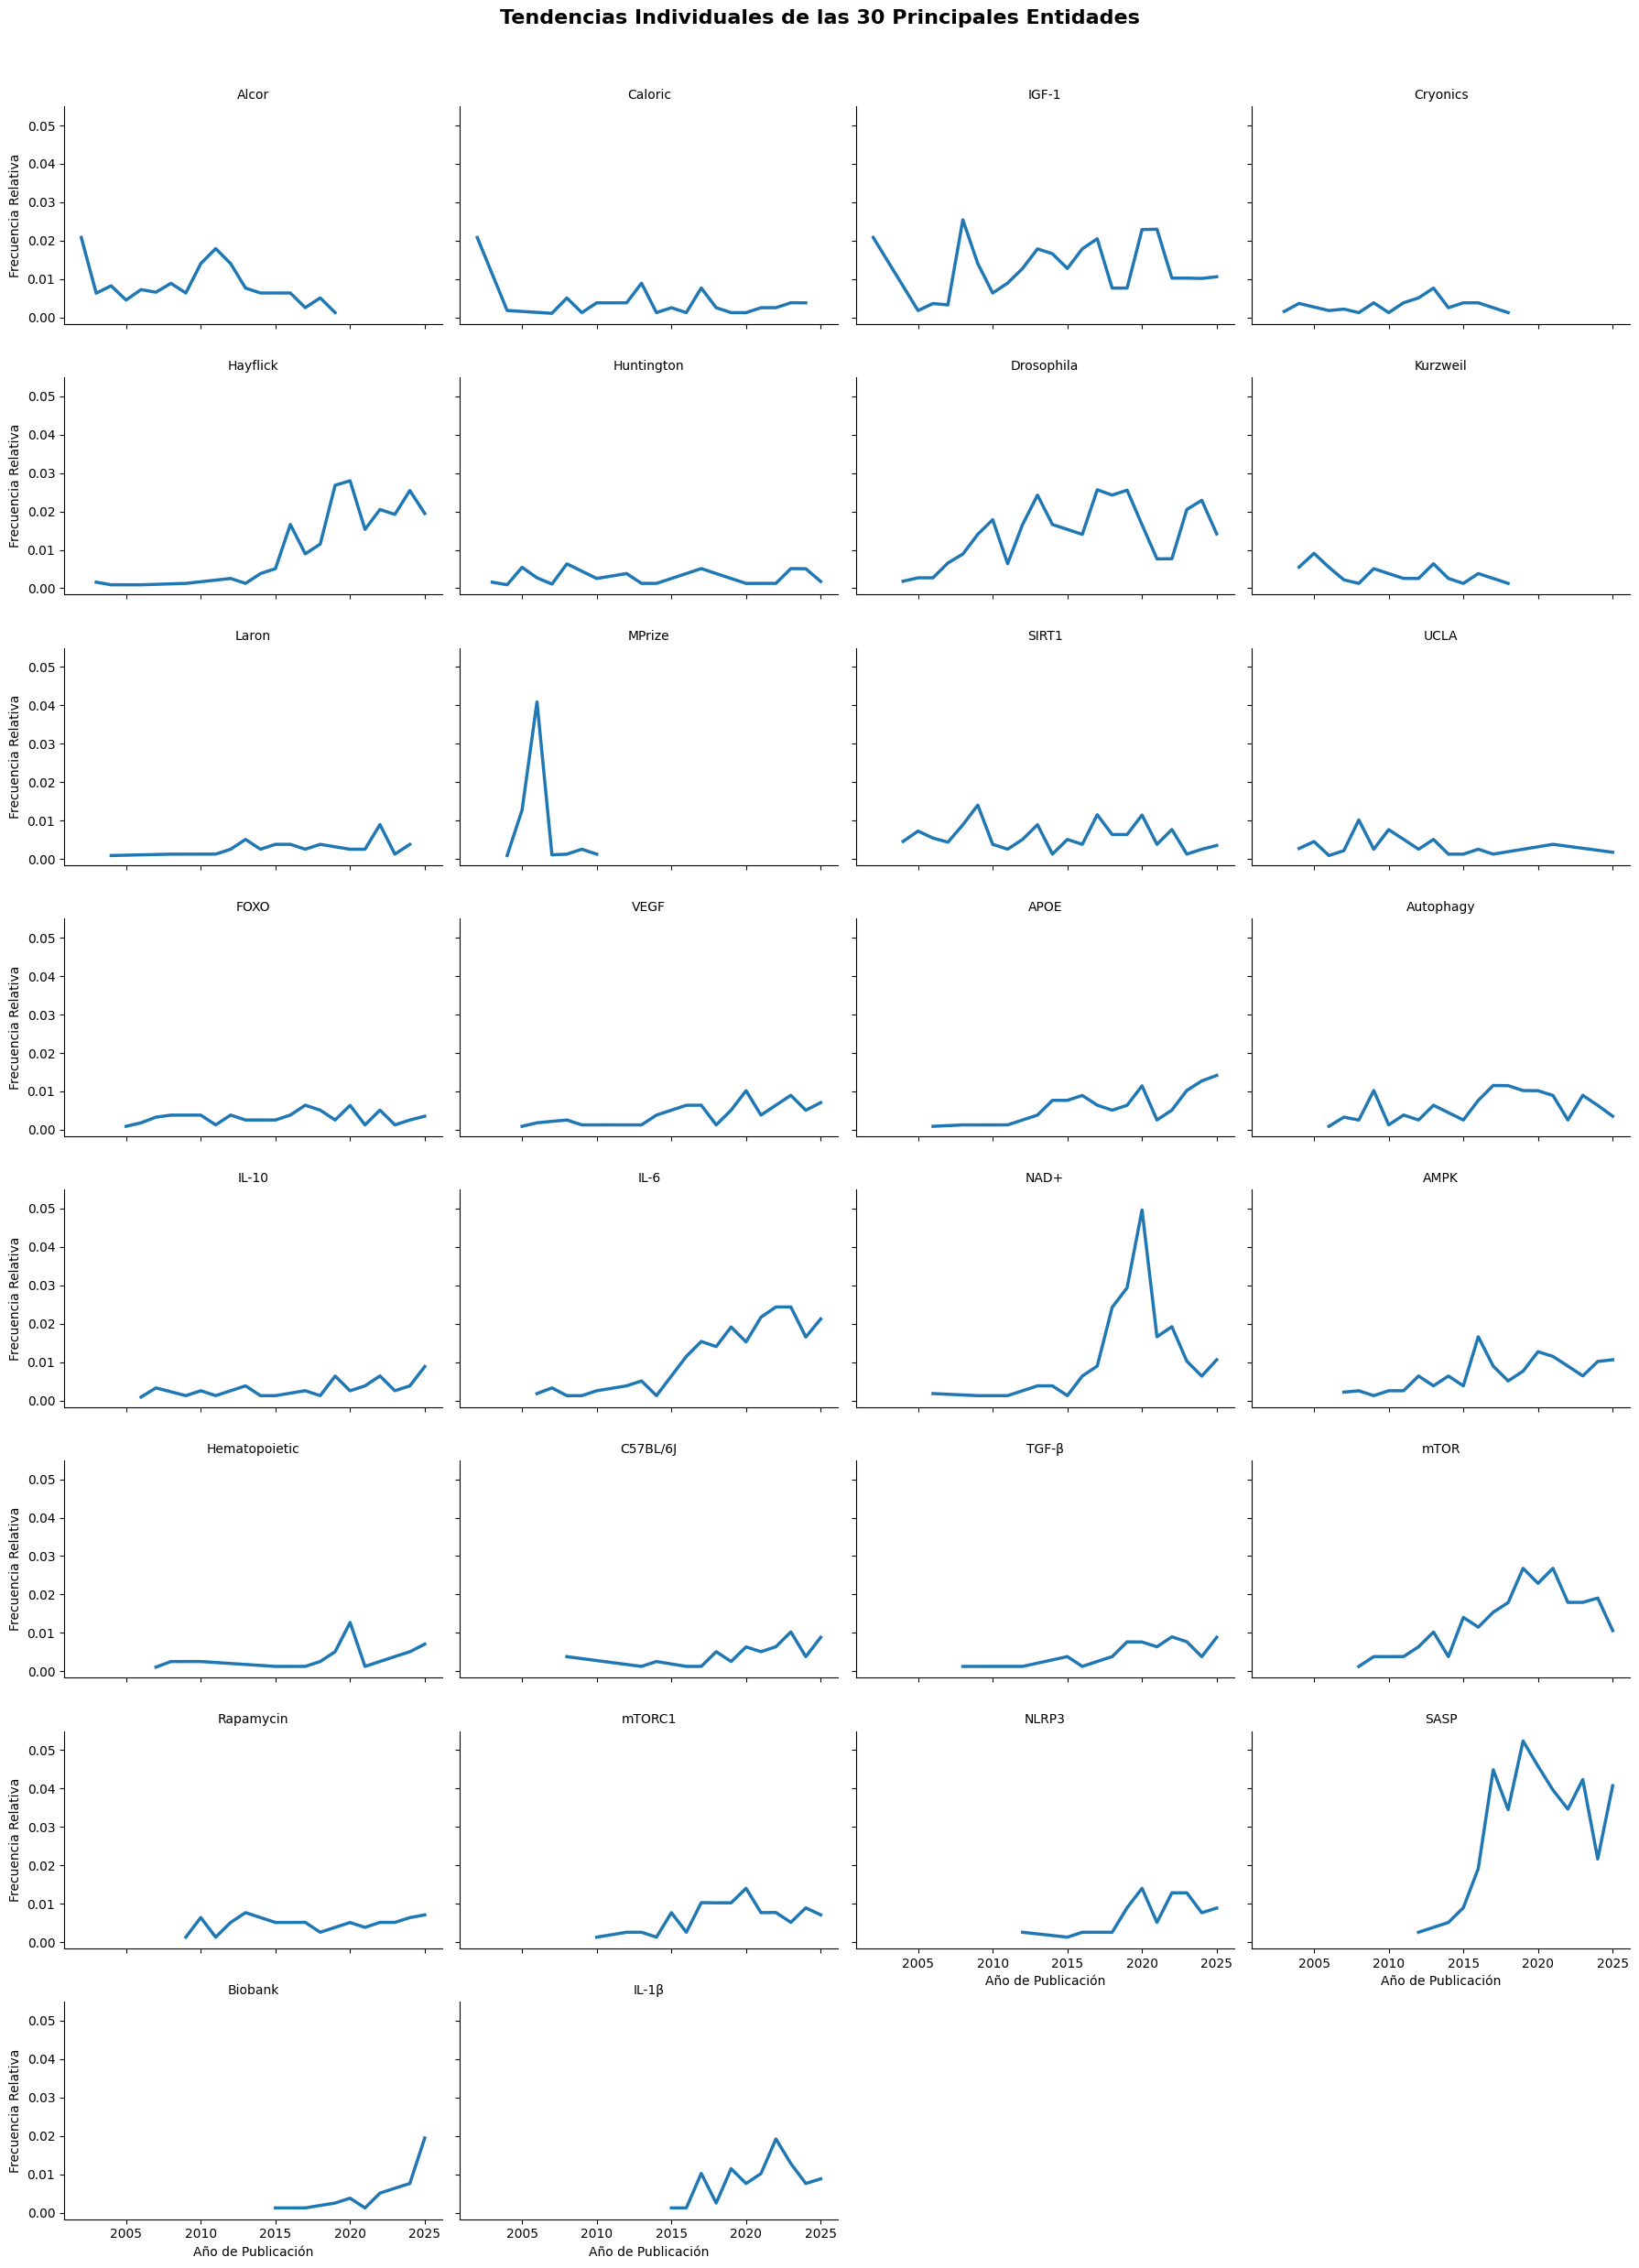

In [45]:
# PASO 7b: VISUALIZACIÓN CON GRÁFICOS DE FACETAS

print("\n--- PASO 7b: Generando Gráficos de Facetas ---")

# Usamos el mismo 'plot_df' del Top 15 de tu código anterior
# (O puedes recalcularlo con el N que prefieras)
N_TOP_ENTITIES = 30
top_entities = entity_trends.groupby('entity_name')['count'].sum().nlargest(N_TOP_ENTITIES).index
facet_df = entity_trends[entity_trends['entity_name'].isin(top_entities)]


# Usamos relplot para crear la cuadrícula automáticamente
g = sns.relplot(
    data=facet_df,
    x='year',
    y='frequency',
    col='entity_name', # Crea una columna de gráficos para cada entidad
    col_wrap=4,        # Envuelve la cuadrícula cada 4 gráficos
    kind='line',       # El tipo de gráfico es de líneas
    height=3,          # Altura de cada gráfico pequeño
    aspect=1.5,        # Relación de aspecto
    linewidth=2.5
)

g.fig.suptitle(f'Tendencias Individuales de las {N_TOP_ENTITIES} Principales Entidades', y=1.03, fontsize=16, weight='bold')
g.set_titles("{col_name}")
g.set_axis_labels("Año de Publicación", "Frecuencia Relativa")
plt.savefig('facet_grid_tendencias.png', dpi=300, bbox_inches='tight')
plt.show()